# Graded Lab 04
<a target="_blank" href="https://colab.research.google.com/github/andrew-nash/CS6421-labs-2026/blob/main/Lab04.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This lab will guide you through the implementation of a CNN-based autoencoder for image anomaly detection.

The main purpose of the lab is to encourage you to develop the practical skill of Hyper-parameter optimization. To do this, we will employ some architectures, namely the CNN and Autoencoder, that you will see much more detail of in upcoming lectures. This lab introduces the concepts of both Autoencoders and CNNs. This lab remains agnostic of the specifics of how CNNs are implemented, we will spare this detail for a future lab.

Marks will be awarded for each task.


Within each task, 20% of marks (1 mark) will be awarded for meeting the specified performance criteria.

The remaining 80% of marks (4 marks) are awarded based on the quality of explanation. The scale of marking is as follows


0. No explanation or justification of final chosen model
1. Little, or incorrect explanation of the observed results, and justification of the final choice of model
2. Some partially correct explanation of the results, and justification of the final choice of model
3. Valid explanation of the results, but no justification of the final choice of model (and vice versa)
4. Valid explanation of the results, positive justification of the final choice of model

Within your explanations, you should consider the train and validation loss, any indications of under- and over- fitting, generalisation, whether vanishing gradients are present,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import requests # Added for downloading the dataset
import os       # Added for file path operations
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import datetime

# Specify the device on which this will be run
device = torch.device("cpu")

# Data

The dataset that we will use is the UCI dataset for recognition of handwritten digits https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits  

Each sample consists of an 8 pixel by 8 pixel greyscale image of a digit. Each pixel is represented by an integer in the range [0,16]

In [2]:
class UCI_Digits_Dataset(torch.utils.data.Dataset):
    # 8,12,0,16, . . 15,7
    # 64 pixel values [0-16], digit [0-9]

    def __init__(self, src_file, n_rows=None):
        # the data is stored as a flat vector of 65 values - 64 pixels, and a label
        all_xy = np.loadtxt(src_file, max_rows=n_rows,
          usecols=range(0,65), delimiter=",", comments="#",
          dtype=np.float32)

        # reshape this so each image is stored as an [8x8] matrix

        self.img_data = torch.tensor(all_xy[:,0:64], dtype=torch.float).to(device).reshape(-1,8,8)
        # normalise so pixel values are in the range [0,1]
        self.img_data/=16.0
        self.label_data = torch.tensor(all_xy[:,64], dtype=torch.float).to(device)


    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        return self.img_data[idx],self.label_data[idx]


We can define a function that allows us to simply extract single data samples from the dataset, and visualise them as follows:

In [3]:
def display_digit(ds, idx, save=False):
    # ds is a PyTorch Dataset
    X, label = ds[idx]  # tensor
    img = np.array(X)  # numpy row of pixels
    print("\ndigit = ", str(label), "\n")

    for i in range(8):
        for j in range(8):
            pxl = img[i,j]  # or [i][j] syntax
            pxl = int(pxl * 16.0)  # denormalize
            print("%.2X" % pxl, end="")
            print(" ", end="")
        print("")

    plt.imshow(img, cmap=plt.get_cmap('gray_r'))
    if save == True:
        plt.savefig("./idx_" + str(idx) + "_digit_" +
        str(label) + ".jpg", bbox_inches='tight')
    plt.show()
    plt.close()

def display_digits(ds, idxs, save=False):
    # idxs is a list of indices
    for idx in idxs:
        display_digit(ds, idx, save)

## Downloading the Data and Creating the torch Dataset

In [6]:
# 0. get started
print("\nBegin UCI Digits autoencoder anomaly demo ")

# 1. create Dataset object
print("\nLoading data as normalized tensors ")

# Download the dataset from URL
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
local_file_name = "optdigits.tra"

print(f"Downloading dataset from {data_url} to {local_file_name}")
try:
    response = requests.get(data_url)
    response.raise_for_status() # Raise an exception for HTTP errors
    with open(local_file_name, 'wb') as f:
        f.write(response.content)
    print("Download complete.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the dataset: {e}")


Begin UCI Digits autoencoder anomaly demo 

Loading data as normalized tensors 
Download complete.


In [7]:
data_ds = UCI_Digits_Dataset(local_file_name)  # all rows

train, val = torch.utils.data.random_split(data_ds, [0.8,0.2], generator=torch.Generator().manual_seed(42))


digit =  tensor(9.) 

00 01 10 10 0F 05 00 00 
00 01 10 0D 09 0F 03 00 
00 03 10 00 05 10 05 00 
00 00 0C 10 10 10 06 00 
00 00 01 04 04 0C 05 00 
00 00 00 00 00 0C 09 00 
00 00 01 00 02 0E 07 00 
00 00 0C 10 10 0F 03 00 


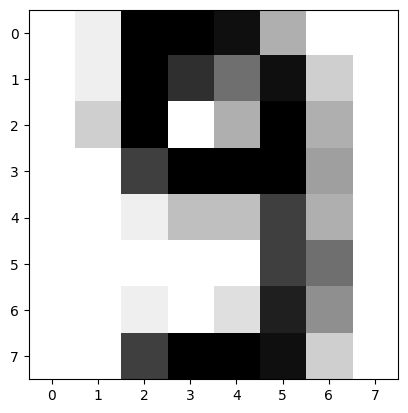

In [8]:
display_digit(train, 0)

# Introduction to Auto-encoders

In this assignment, we will create a **simple autoencoder** model.

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

 1) Autoencoders are _data-specific_, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are _lossy_, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are _learned automatically from data examples_, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent.

In general, a neural network is a computational model that is used for finding a function describing the relationship between data features $x$ and its values or labels $y$, i.e. $y = f(x)$.
An autoencoder is specific type of neural network, which consists of encoder and decoder components: (1) the **encoder**, which learns a compressed data representation $z$, and (2) the **decoder**, which reconstructs the data $\hat{x}$ based on its idea $z$ of how it is structured:
$$ z = f\big(h_{e}(x)\big)$$
$$ \hat{x} = f\big(h_{d}(z)\big),$$
where $z$ is the learned data representation by encoder $h_{e}$, and $\hat{x}$ is the reconstructed data by decoder $h_{d}$ based on $z$.


The encoder and decoder are defined as:
$$ z = f\big(h_{e}(x)\big)$$
$$ \hat{x} = f\big(h_{d}(z)\big),$$
where $z$ is the compressed data representation generated by encoder $h_{e}$, and $\hat{x}$ is the reconstructed data generated by decoder $h_{d}$ based on $z$.

<div align="center"><img src="https://github.com/benjaminirving/mlseminars-autoencoders/blob/master/imgs/d1.png?raw=1" width="80%"></div>

In this figure, we take as input an image, and compress that image before decompressing it using a neural network.

There are many resources that explain the operation of Autoencoders online. Particularly interesing is https://compneuro.neuromatch.io/tutorials/Bonus_Autoencoders/student/Bonus_Tutorial1.html, which provides an excellent example of an Autoencoder for a similar use case, as well as an interesting comparison of deep encoders to PCA decomposition.

Some of the key uses of deep autoencoders are:

1. Data compression
2. Denoising
3. Anomaly Detection

You will soon see more about Autoencoders in upcoming lectures.

## A Basic Autoencoder Using Fully Connected Layers

The following is a basic example of an autoencoder on this data, based on the basic fully connected neural network that we have seen thus far.

In [9]:
def fc_train_loop(dataloader, model, loss_fn, optimizer, epoch, writer):

    # Set the model in training mode
    model.train()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    correct = 0
    total_loss = 0
    for batch, (X,label) in enumerate(dataloader):
        # We will pass in 2D images, but want to work with simple vector inputs
        # And so we willl 'Flatten' all inputs -- i.e., reshape it from (batch, 8, 8)
        # to (batch, 64)
        X = X.float().reshape(-1, 64)

        # IMPORTANT, WE DON'T USE THE DATASET'S OWN Y
        # INSTEAD WE FIT AGAINST X
        Y = X
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, Y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # every 10th batch, log the gradients
        if batch % 10 == 0:
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

        # now zero the gradients
        optimizer.zero_grad()

        with torch.no_grad():
            total_loss += loss.item()


    ## Log Metrics in TensorBoard
    avg_batchloss = total_loss / num_batches
    writer.add_scalar('Loss/train', avg_batchloss, epoch)
    print(f"Train Error: Avg loss: {avg_batchloss:>8f} \n")




def fc_val_loop(dataloader, model, loss_fn, epoch, writer):


    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_batchloss = 0

    with torch.no_grad():
        for X, label in dataloader:
            X = X.float().reshape(-1, 64)
            Y = X

            pred = model(X)
            test_batchloss += loss_fn(pred, Y).item()

    test_batchloss /= num_batches

    writer.add_scalar('Loss/val', test_batchloss, epoch)
    print(f"Val Error: Avg loss: {test_batchloss:>8f} \n")



In [10]:

class BasicFCAutoencoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(BasicFCAutoencoder, self).__init__()
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 32)
        self.fc4 = nn.Linear(32, output_size)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        return x

# for an autoencoder, input and output sizes
# must be identical
input_size = output_size = 64

model = BasicFCAutoencoder(input_size, output_size)
print(model)

BasicFCAutoencoder(
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
)


In [11]:
learning_rate = 1e-3
batch_size = 16
epochs = 5

run_name = f"logs/BasicModel/{datetime.datetime.now().strftime('%b%d_%H-%M-%S')}"
writer = SummaryWriter(run_name)

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_dataloader  =  DataLoader(val, batch_size=batch_size, shuffle=False)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for t in range(1, epochs+1):
    print(f"Epoch {t}\n-------------------------------")
    fc_train_loop(train_dataloader, model, loss_fn, optimizer, t, writer)
    fc_val_loop(val_dataloader, model, loss_fn, t, writer)
print("Done!")

Epoch 1
-------------------------------
Train Error: Avg loss: 0.208512 

Val Error: Avg loss: 0.206605 

Epoch 2
-------------------------------
Train Error: Avg loss: 0.206839 

Val Error: Avg loss: 0.204947 

Epoch 3
-------------------------------
Train Error: Avg loss: 0.205178 

Val Error: Avg loss: 0.203302 

Epoch 4
-------------------------------
Train Error: Avg loss: 0.203529 

Val Error: Avg loss: 0.201673 

Epoch 5
-------------------------------
Train Error: Avg loss: 0.201901 

Val Error: Avg loss: 0.200072 

Done!


# Introduction to CNNs


## CNN Layers
Convolutional Neural Networks are also something you will see more details of in upcoming lectures.

Consider how the data which we are passing to our model consists of 8x8 images, which we convert into 64-length vectors. These vectors discrad the spatial relationships within the grid of pixels that make up the image.

Convolutional Neural Nets provide a basic architecture that preserves inputs as 2D images. Instead of maintaining a *weight matrix*, it maintaines a set of (usually square) *filters* (also known as *kernels*), which are smaller than the size of the input image.




<img src='https://media.datacamp.com/legacy/v1700043905/image10_f8b261ebf1.png' width='750px'>

Each $k\times k$ filter is applied to $k\times k$ sub-regions of the inputted image, with a convolution operation.
<table>
    <tr>
        <td><img src='https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif' width="500px"/></td><td><img src='https://towardsdatascience.com/wp-content/uploads/2020/08/1r13ZUdVTQwVuhDPmo3JKag.png' width='500px'/></td>
    </tr>
</table>

Typically, each CNN layer will contain a number of equally sized filters operating in parallel.

## Pooling Layers

Following each CNN layer, the dimension of the resulting activation map is usually reduced by means of a Pooling layer. This applies a $p\times p$ grid over non-overlapping regions of the activation map. Only the maximum value in each grid is retained in the output

<img src='https://towardsdatascience.com/wp-content/uploads/2020/08/1sK7oP1m129V_oNGSsHIm_w.png' width='500px'/>


You see the detailed mathematics of this in the lecture material.

## Deconvolution/Transposed Convolution

In order to take the compressed intermediate represenation, and reproduce an image of the same dimension as the input, we require some inverse function for the pooling operation - i.e., taking a small image/activation map, and producing a larger activation map from it. The function we use for this is the Transpose Convolution. This takes a single pixel from the input map, and multiplies it by a kernel/filter. These maps are then combined to form an enlarged output map.

https://medium.com/data-science/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967

(All images credit: https://medium.com/sfu-cspmp/an-introduction-to-convolutional-neural-network-cnn-207cdb53db97)

# Defining and Training a CNN Based Autoencoder

We will require new train and validation loops, which will pass data to the model as batches of $8\times 8$ images

In [15]:
def cnn_train_loop(dataloader, model, loss_fn, optimizer, epoch, writer):

    # Set the model in training mode
    model.train()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    correct = 0
    total_loss = 0
    for batch, (X,label) in enumerate(dataloader):


        # We will pass in 2D images, without flattening
        # However, we still need to reshape ...
        # This is to add channel information to the data, even though
        # it is a single channel image
        X = X.float().reshape(-1,1,8,8)
        # IMPORTANT, WE DON'T USE THE DATASET'S OWN Y
        # INSTEAD WE FIT AGAINST X
        Y = X


        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, Y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # every 10th batch, log the gradients
        if batch % 10 == 0:
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

        # now zero the gradients
        optimizer.zero_grad()

        with torch.no_grad():
            total_loss += loss.item()


    ## Log Metrics in TensorBoard
    avg_batchloss = total_loss / num_batches
    writer.add_scalar('Loss/train', avg_batchloss, epoch)
    print(f"Train Error: Avg loss: {avg_batchloss:>8f} \n")




def cnn_val_loop(dataloader, model, loss_fn, epoch, writer):


    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_batchloss = 0

    with torch.no_grad():
        for X, label in dataloader:
            # We will pass in 2D images, without flattening
            # However, we still need to reshape ...
            # This is to add channel information to the data, even though
            # it is a single channel image
            X = X.float().reshape(-1,1,8,8)
            # IMPORTANT, WE DON'T USE THE DATASET'S OWN Y
            # INSTEAD WE FIT AGAINST X
            Y = X

            pred = model(X)
            test_batchloss += loss_fn(pred, Y).item()

    test_batchloss /= num_batches

    writer.add_scalar('Loss/val', test_batchloss, epoch)
    print(f"Val Error: Avg loss: {test_batchloss:>8f} \n")



In [23]:

class BasicCNNAutoencoder(nn.Module):
    def __init__(self):
        super(BasicCNNAutoencoder, self).__init__()
        self.relu = nn.ReLU()


        number_filters = 4
        filter_size = 2
        pool_size = 2

        ### ENCODER

        # in_channels is the number of channels in the input image. The fact that our inputs
        # are matrices (shape 8x8) of floats means that they are single-channel images
        # Images with separate Red, Green and Blue channel inputs (shape 8x8x3) would require 3 in_channels

        # out_channels is the number of kernels/filters to use

        # kernel_size is the width and height of the filters to apply

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=number_filters, kernel_size=filter_size)
        # the size of pooling to apply
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size)

        # In practice, you can apply more convolution layers here ...
        # at this stage, you need to check the number of activations after pool1


        ### DECODER

        # the stride MUST be set equal to the pool_size of the max_pool, otherwise the resuling output will not have the correct shape
        self.deconv1 = nn.ConvTranspose2d(in_channels=number_filters, out_channels=1, kernel_size=number_filters, stride=pool_size)



    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.deconv1(x)
        return x

# for an autoencoder, input and output sizes
# must be identical
input_size = output_size = 64

model = BasicCNNAutoencoder()
print(model)

BasicCNNAutoencoder(
  (relu): ReLU()
  (conv1): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose2d(4, 1, kernel_size=(4, 4), stride=(2, 2))
)


In [26]:
learning_rate = 1e-3
batch_size = 16
epochs = 5

run_name = f"logs/BasicCNNModel/{datetime.datetime.now().strftime('%b%d_%H-%M-%S')}"
writer = SummaryWriter(run_name)

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_dataloader  =  DataLoader(val, batch_size=batch_size, shuffle=False)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for t in range(1, epochs+1):
    print(f"Epoch {t}\n-------------------------------")
    cnn_train_loop(train_dataloader, model, loss_fn, optimizer, t, writer)
    cnn_val_loop(val_dataloader, model, loss_fn, t, writer)
print("Done!")

Epoch 1
-------------------------------
Train Error: Avg loss: 0.142032 

Val Error: Avg loss: 0.140982 

Epoch 2
-------------------------------
Train Error: Avg loss: 0.140881 

Val Error: Avg loss: 0.140110 

Epoch 3
-------------------------------
Train Error: Avg loss: 0.140125 

Val Error: Avg loss: 0.139485 

Epoch 4
-------------------------------
Train Error: Avg loss: 0.139547 

Val Error: Avg loss: 0.138970 

Epoch 5
-------------------------------
Train Error: Avg loss: 0.139051 

Val Error: Avg loss: 0.138502 

Done!


### Determining the bottleneck/intermediate representation size

It is not so easy for this particular model (compared to the feedforward model), to determine what the dimension of the encoded representation/bottleneck/latent/intermediate representation is.

The torchinfo module can give us better insights into our model to make this, and other observations.

In [18]:
%pip install torchinfo

In [19]:
from torchinfo import summary

In [20]:
summary(model, input_data = torch.zeros(1,8,8, device=device))

Layer (type:depth-idx)                   Output Shape              Param #
BasicCNNAutoencoder                      [1, 10, 10]               --
├─Conv2d: 1-1                            [4, 8, 8]                 20
├─ReLU: 1-2                              [4, 8, 8]                 --
├─MaxPool2d: 1-3                         [4, 4, 4]                 --
├─ConvTranspose2d: 1-4                   [1, 10, 10]               65
Total params: 85
Trainable params: 85
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

We can see that this model's bottleneck size is $4*3*3=36$. We can also see that the model has only 85 total trainable parameters (weights), significantly smaller than the feedforward model, which has equivalent performance.

## Multi-layer Encoder and Decoder

The previous CNN model featured only one and CNN and pooling layer in the Encoder, and one deconvolution. Here, we demonstrate a multi-layer CNN autoencoder

In [27]:
class MultiCNNAutoencoder(nn.Module):
    def __init__(self):
        super(MultiCNNAutoencoder, self).__init__()
        self.relu = nn.ReLU()

        ### ENCODER
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=2, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2)


        ### DECODER
        # we should have 2 decovolution layers, as we had 2 pooling layers. An alternative would be to have
        # a single decovolution layer with both kernel size and stride 4
        self.deconv1 = nn.ConvTranspose2d(in_channels=2, out_channels=2, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=2, stride=2)



    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        return x

# for an autoencoder, input and output sizes
# must be identical
input_size = output_size = 64

model = MultiCNNAutoencoder()
print(model)

MultiCNNAutoencoder(
  (relu): ReLU()
  (conv1): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 2, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose2d(2, 2, kernel_size=(2, 2), stride=(2, 2))
  (deconv2): ConvTranspose2d(2, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [28]:
summary(model, input_data = torch.zeros(1,8,8, device=device))

Layer (type:depth-idx)                   Output Shape              Param #
MultiCNNAutoencoder                      [1, 8, 8]                 --
├─Conv2d: 1-1                            [4, 8, 8]                 20
├─ReLU: 1-2                              [4, 8, 8]                 --
├─MaxPool2d: 1-3                         [4, 4, 4]                 --
├─Conv2d: 1-4                            [2, 4, 4]                 34
├─ReLU: 1-5                              [2, 4, 4]                 --
├─MaxPool2d: 1-6                         [2, 2, 2]                 --
├─ConvTranspose2d: 1-7                   [2, 4, 4]                 18
├─ReLU: 1-8                              [2, 4, 4]                 --
├─ConvTranspose2d: 1-9                   [1, 8, 8]                 9
Total params: 81
Trainable params: 81
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Notice here that the intermediate representation has size $2*2*2=8$ weights

In [29]:
learning_rate = 1e-3
batch_size = 16
epochs = 5

run_name = f"logs/MultiCNNModel/{datetime.datetime.now().strftime('%b%d_%H-%M-%S')}"
writer = SummaryWriter(run_name)

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_dataloader  =  DataLoader(val, batch_size=batch_size, shuffle=False)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for t in range(1, epochs+1):
    print(f"Epoch {t}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, t, writer)
    val_loop(val_dataloader, model, loss_fn, t, writer)
print("Done!")

Epoch 1
-------------------------------
Train Error: Avg loss: 0.425869 

Val Error: Avg loss: 0.328450 

Epoch 2
-------------------------------
Train Error: Avg loss: 0.273793 

Val Error: Avg loss: 0.228128 

Epoch 3
-------------------------------
Train Error: Avg loss: 0.203302 

Val Error: Avg loss: 0.181735 

Epoch 4
-------------------------------
Train Error: Avg loss: 0.170628 

Val Error: Avg loss: 0.160306 

Epoch 5
-------------------------------
Train Error: Avg loss: 0.155482 

Val Error: Avg loss: 0.150423 

Done!


# Hyper-parameter Searching, Graded Task

The graded aspect of this lab will be to evaluate the peformance of different CNN based autoencoders for various choices of hyper-parameter. The following is an example of searhcing over numbers of layers, and layer sizes for the simple Fully Connected Autoencoder.

In [ ]:

class HSFCAutoencoder(nn.Module):
    def __init__(self, input_size, output_size, num_layers, layer_sizes):
        super(HSFCAutoencoder, self).__init__()

        # this is a way of storing a variable number of layers, rather than using self.xxxx
        self.layers = nn.ModuleList()
        layer_input_size = input_size

        for layer_size in layer_sizes:
            self.layers.append(nn.Linear(layer_input_size, layer_size))
            # the next layer's input size is this layer's output size
            layer_input_size=layer_size
            # we could apply the activations here, or define a single relu() above, and apply it
            # in forward()
            self.layers.append(nn.ReLU())


    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

# for an autoencoder, input and output sizes
# must be identical
input_size = output_size = 64

eg_model = HSFCAutoencoder(input_size, output_size, 4, [32,16,32,64])
summary(eg_model, input_data = torch.zeros(64, device=device))

Layer (type:depth-idx)                   Output Shape              Param #
HSFCAutoencoder                          [64]                      --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32]                      2,080
│    └─ReLU: 2-2                         [32]                      --
│    └─Linear: 2-3                       [16]                      528
│    └─ReLU: 2-4                         [16]                      --
│    └─Linear: 2-5                       [32]                      544
│    └─ReLU: 2-6                         [32]                      --
│    └─Linear: 2-7                       [64]                      2,112
│    └─ReLU: 2-8                         [64]                      --
Total params: 5,264
Trainable params: 5,264
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.23
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB):

It is worth re-defining the train and val loops to only print the final losses. Detailed losses can be found in the TensorBoard output.

In [ ]:
def fc_train_loop(dataloader, model, loss_fn, optimizer, epoch, writer):

    # Set the model in training mode
    model.train()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    correct = 0
    total_loss = 0
    for batch, (X,label) in enumerate(dataloader):
        # We will pass in 2D images, but want to work with simple vector inputs
        # And so we willl 'Flatten' all inputs -- i.e., reshape it from (batch, 8, 8)
        # to (batch, 64)
        X = X.float().reshape(-1, 64)

        # IMPORTANT, WE DON'T USE THE DATASET'S OWN Y
        # INSTEAD WE FIT AGAINST X
        Y = X
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, Y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # every 10th batch, log the gradients
        if batch % 10 == 0:
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

        # now zero the gradients
        optimizer.zero_grad()

        with torch.no_grad():
            total_loss += loss.item()


    ## Log Metrics in TensorBoard
    avg_batchloss = total_loss / num_batches
    writer.add_scalar('Loss/train', avg_batchloss, epoch)
    #print(f"Train Error: Avg loss: {avg_batchloss:>8f} \n")
    return avg_batchloss



def fc_val_loop(dataloader, model, loss_fn, epoch, writer):


    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_batchloss = 0

    with torch.no_grad():
        for X, label in dataloader:
            X = X.float().reshape(-1, 64)
            Y = X

            pred = model(X)
            test_batchloss += loss_fn(pred, Y).item()

    test_batchloss /= num_batches

    writer.add_scalar('Loss/val', test_batchloss, epoch)
    #print(f"Val Error: Avg loss: {test_batchloss:>8f} \n")
    return test_batchloss



Searching over a set of possible models:

## 4 Layer Models

In [ ]:
n_layers = 3
layer_size_searches =[
    [52,32,52,64],
    [32,16,32,64],
    [16,8,16,64],
    [8,4,8,64],
]

for search_no, layer_sizes in enumerate(layer_size_searches):
    input_size = output_size = 64

    print(f'\n### Search {layer_sizes} ####')

    #create the model based on the specific search
    model = HSFCAutoencoder(input_size, output_size, 3, layer_sizes)
    learning_rate = 1e-3
    batch_size = 16
    epochs = 10

    run_name = f"logs/FC_4_layers_search_{search_no}/{datetime.datetime.now().strftime('%b%d_%H-%M-%S')}"
    writer = SummaryWriter(run_name)

    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=False)
    val_dataloader  =  DataLoader(val, batch_size=batch_size, shuffle=False)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


    for t in range(1, epochs+1):
        train_loss = fc_train_loop(train_dataloader, model, loss_fn, optimizer, t, writer)
        val_loss = fc_val_loop(val_dataloader, model, loss_fn, t, writer)
    print(f"Final Train Avg loss: {train_loss:>8f}")
    print(f"Final Val Avg loss: {val_loss:>8f} \n")
    print("Done!")


### Search [52, 32, 52, 64] ####
Final Train Avg loss: 29.019899
Final Val Avg loss: 28.990100 

Done!

### Search [32, 16, 32, 64] ####
Final Train Avg loss: 16.448366
Final Val Avg loss: 16.067494 

Done!

### Search [16, 8, 16, 64] ####
Final Train Avg loss: 26.577684
Final Val Avg loss: 25.066806 

Done!

### Search [8, 4, 8, 64] ####
Final Train Avg loss: 37.516251
Final Val Avg loss: 37.322013 

Done!


## Task 1: Number of Layers, and CNN Layer Parameters

This task requires you to perform hyper-parameter tuning over the following sets of hyper-parameters:


1. For a simple 1 layer encoder/1 layer decoder model (CONV->POOL->RELU->DECONV): Consider a possible number of channels between 1 and 8 the CONV and DECONV layers. Maintain kernel_size as 2 in all cases
2. For a simple 2 layer encoder/2 layer decoder model (CONV->POOL->RELU->CONV->POOL->RELU->DECONV->RELU->DECONV): Consider a possible number of channels between 1 and 8 for each CONV and DECONV layer. Maintain kernel_size as 2 in all cases

Number of epochs, batch size and learning rate are at your discretion.

Evaluate each, and determine which has, in your view, the best performance as an autoencoder. Refer to both the Training and Validation loss, as well as the size of the bottleneck of particular models of interest.

In [ ]:
def hs_train_loop(dataloader, model, loss_fn, optimizer, epoch, writer):

    # Set the model in training mode
    model.train()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    correct = 0
    total_loss = 0
    for batch, (X,label) in enumerate(dataloader):
        # We will pass in 2D images, but want to work with simple vector inputs
        # And so we willl 'Flatten' all inputs -- i.e., reshape it from (batch, 8, 8)
        # to (batch, 64)
        X = X.float().reshape(-1, 1, 8, 8)

        # IMPORTANT, WE DON'T USE THE DATASET'S OWN Y
        # INSTEAD WE FIT AGAINST X
        Y = X
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, Y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # every 10th batch, log the gradients
        if batch % 10 == 0:
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

        # now zero the gradients
        optimizer.zero_grad()

        with torch.no_grad():
            total_loss += loss.item()


    ## Log Metrics in TensorBoard
    avg_batchloss = total_loss / num_batches
    writer.add_scalar('Loss/train', avg_batchloss, epoch)
    #print(f"Train Error: Avg loss: {avg_batchloss:>8f} \n")
    return avg_batchloss



def hs_val_loop(dataloader, model, loss_fn, epoch, writer):


    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_batchloss = 0

    with torch.no_grad():
        for X, label in dataloader:
            X = X.float().reshape(-1, 1, 8, 8)
            Y = X

            pred = model(X)
            test_batchloss += loss_fn(pred, Y).item()

    test_batchloss /= num_batches

    writer.add_scalar('Loss/val', test_batchloss, epoch)
    #print(f"Val Error: Avg loss: {test_batchloss:>8f} \n")
    return test_batchloss



In [ ]:
class HS_1_Layer_CNNAutoencoder(nn.Module):
    def __init__(self, .......):
        super(HS_1_Layer_CNNAutoencoder, self).__init__()
        self.relu = nn.ReLU()

        ### ENCODER
        self.conv1 = nn.Conv2d(in_channels=1, out_channels= ...., kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2)



        ### DECODER
        # we should have 2 decovolution layers, as we had 2 pooling layers. An alternative would be to have
        # a single decovolution layer with both kernel size and stride 4
        self.deconv1 = nn.ConvTranspose2d(in_channels=2, out_channels=....., kernel_size=2, stride=2)



    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.deconv1(x)

        return x


In [ ]:
'''
Search Parameters
'''

for .... in ....:
    input_size = output_size = 64


    #create the model based on the specific search
    model = HS_1_Layer_CNNAutoencoder(.....)

    learning_rate = ....
    batch_size = ....
    epochs =  ....

    run_name = f"logs/.........../{datetime.datetime.now().strftime('%b%d_%H-%M-%S')}"
    writer = SummaryWriter(run_name)

    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=False)
    val_dataloader  =  DataLoader(val, batch_size=batch_size, shuffle=False)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


    for t in range(1, epochs+1):
        train_loss = hs_train_loop(train_dataloader, model, loss_fn, optimizer, t, writer)
        val_loss = hs_val_loop(val_dataloader, model, loss_fn, t, writer)
    print(f"Final Train Avg loss: {train_loss:>8f}")
    print(f"Final Val Avg loss: {val_loss:>8f} \n")
    print("Done!")

In [ ]:
.... repeat for HS_2_Layer_CNNAutoencoder

class HS_1_Layer_CNNAutoencoder.....

In [ ]:
explanation_of_chosen_model = '''
     In this string, explain which out of the models you evaluated, across both 1 and 2 layer CNN autoencoders performed best.

     Refer to bottleneck size, and the validaiton and train losses. Explain *why* you think that this model may perform best out of all the alternatives.

     In basic terms, explain your choice of number of epochs, batch size and learning rate
'''

For the purposes of assessing your work, export this trained model.

In [ ]:
# Create a sample input
sample_input = torch.randn(1,8,8)

# Export the model
exported_program = torch.export.export( CHOSEN_MODEL_CLASS(), sample_input)

# Save the exported program
torch.export.save(exported_program, 'TASK1_model.pt')

# Save the trained weights
torch.save(CHOSEN_MODEL.state_dict(), 'TASK1_weights.pt')


NameError: name 'CHOSEN_MODEL_CLASS' is not defined

## Task 2: Dropout

Dropout, as discussed in the lecutres, can be used to add regularisation and improve performance. It is applied in PyTorch as follows:

In [ ]:

class HSFCAutoencoder(nn.Module):
    def __init__(self, input_size, output_size, num_layers, layer_sizes):
        super(HSFCAutoencoder, self).__init__()

        # this is a way of storing a variable number of layers, rather than using self.xxxx
        self.layers = nn.ModuleList()
        layer_input_size = input_size

        for layer_size in layer_sizes:
            self.layers.append(nn.Linear(layer_input_size, layer_size))
            # HERE IS THE ONLY CHANGE
            self.layers.append(nn.Dropout(p=0.2))

            # the next layer's input size is this layer's output size
            layer_input_size=layer_size
            # we could apply the activations here, or define a single relu() above, and apply it
            # in forward()
            self.layers.append(nn.ReLU())


    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

# for an autoencoder, input and output sizes
# must be identical
input_size = output_size = 64

eg_model = HSFCAutoencoder(input_size, output_size, 4, [32,16,32,64])
summary(eg_model, input_data = torch.zeros(64, device=device))

Layer (type:depth-idx)                   Output Shape              Param #
HSFCAutoencoder                          [64]                      --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32]                      2,080
│    └─Dropout: 2-2                      [32]                      --
│    └─ReLU: 2-3                         [32]                      --
│    └─Linear: 2-4                       [16]                      528
│    └─Dropout: 2-5                      [16]                      --
│    └─ReLU: 2-6                         [16]                      --
│    └─Linear: 2-7                       [32]                      544
│    └─Dropout: 2-8                      [32]                      --
│    └─ReLU: 2-9                         [32]                      --
│    └─Linear: 2-10                      [64]                      2,112
│    └─Dropout: 2-11                     [64]                      --
│    └─

### Graded Task:

1. Choose a number (2-3) of high perofrming models from the previous question
2. Search over a possible range of dropout probabilities on these models.
3. Identify the best performing model, and its assoicated dropout probability -- or 0, if dropout is not appropiate

In [ ]:
explanation_of_chosen_dropout = '''
     In this string, explain which out of the models you evaluated, along with what choice of dropout probabilty performed best

     Explain *why* you think that this model may perform best out of all the alternatives.
'''

In [ ]:
# Create a sample input
sample_input = torch.randn(1,8,8)

# Export the model
exported_program = torch.export.export( CHOSEN_MODEL_CLASS(), sample_input)

# Save the exported program
torch.export.save(exported_program, 'TASK2_model.pt')

# Save the trained weights
torch.save(CHOSEN_MODEL.state_dict(), 'TASK2_weights.pt')


### Task 3: BatchNorm

Batch Normalisation, as per the lecture notes can be applied as follows (for CNN models):

In [ ]:

class BNBasicCNNAutoencoder(nn.Module):
    def __init__(self):
        super(BNBasicCNNAutoencoder, self).__init__()
        self.relu = nn.ReLU()

        number_filters = 4
        filter_size = 2
        pool_size = 2


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=number_filters, kernel_size=filter_size, padding='same')
        # you must pass the number of channels outputted by the previous conv. filter to bacthnorm
        self.b_norm1 = nn.BatchNorm2d(number_filters)

        self.pool1 = nn.MaxPool2d(kernel_size=pool_size)
        self.deconv1 = nn.ConvTranspose2d(in_channels=number_filters, out_channels=1, kernel_size=number_filters, stride=pool_size)



    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.deconv1(x)
        return x



### Graded Task:

1. Choose the most high perofrming model from Task 1
2. Try to add BatchNorm, for some batch sizes between 2 and 64
3. Identify whether BatchNorm has improved performance, and for what batch sizes

In [ ]:
explanation_of_chosen_batchnorm = '''
     In this string, explain which model you chose, and whether each improved or not with BatchNorm for different batch sizes


     Explain *why* this may be
'''

In [ ]:
# Create a sample input
sample_input = torch.randn(1,8,8)

# Export the model
exported_program = torch.export.export( CHOSEN_MODEL_CLASS(), sample_input)

# Save the exported program
torch.export.save(exported_program, 'TASK3_model.pt')

# Save the trained weights
torch.save(CHOSEN_MODEL.state_dict(), 'TASK3_weights.pt')


### Task 4: Regularization
As per the lecture, L1 and L2 regularization can be applied to a model by modifying the loss calculation within the fit() function:



In [ ]:
loss = loss_fn(pred, Y)

# For l1 norm
lambda_reg = 0.01
l1_norm = sum(p.abs().sum() for p in model.parameters())
loss += lambda_reg * l1_norm

# or, for l2 norm:
l2_norm = sum(p.pow(2).sum() for p in model.parameters())
loss += lambda_reg * l2_norm

### Graded Task:

1. Choose the most high perofrming model from Task 1
2. Try to add both L1 and L2, for lambda as 0.001, 0.01 and 0.1 in turn
3. Identify the effect on performance, and which choice (if you identify L1 and L2 norm as improving perofrmance0 is best

In [ ]:
explanation_of_chosen_l_norm = '''
     In this string, explain which regularisation you chose, and *why*
'''

In [ ]:
# Create a sample input
sample_input = torch.randn(1,8,8)

# Export the model
exported_program = torch.export.export( CHOSEN_MODEL_CLASS(), sample_input)

# Save the exported program
torch.export.save(exported_program, 'TASK4_model.pt')

# Save the trained weights
torch.save(CHOSEN_MODEL.state_dict(), 'TASK4_weights.pt')


### Task 5: Open Ended Search

Combining everything you have learned from tasks 1-4, create a final model that incorporates all of your observations.

You may incorporare different activation functions and weight initialisaitons if you desire, but this is not a requirement.

Evaluate the performance of this model -- you should discuss, at the minimum

1. Train and validation loss
2. Whether it shows signs of over or underfitting
3. The bottleneck size
4. The total number of trainable parameters
5. What makes it better and more robust than other models that you considered

In [ ]:
explanation_of_final_model = '''
     In this string, describe the characteristics of your final model. State each hyper-parameter choice you made, and what reason you had for each
'''

In [ ]:
# Create a sample input
sample_input = torch.randn(1,8,8)

# Export the model
exported_program = torch.export.export( CHOSEN_MODEL_CLASS(), sample_input)

# Save the exported program
torch.export.save(exported_program, 'TASK5_model.pt')

# Save the trained weights
torch.save(CHOSEN_MODEL.state_dict(), 'TASK5_weights.pt')
